In [1]:
import pandas as pd
import base
import os
import pickle
from keras.models import load_model
import numpy as np

2024-01-05 06:19:30.755026: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-05 06:19:30.793296: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-05 06:19:30.793335: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-05 06:19:30.794360: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-05 06:19:30.800901: I tensorflow/core/platform/cpu_feature_guar

In [2]:
SEED = 42
base.fix_seed(SEED)

desired_directory = '/home/jovyan/work/spectrum/'
os.chdir(desired_directory)

In [3]:
loaded_posmodel = load_model("Data/03_model/pos/pos_class_model_3")
    
with open('Data/03_model/pos/posmodelcolumn_all.pkl', 'rb') as file:
    loaded_poscolumns = pickle.load(file)
        
with open('Data/03_model/pos/pos_replacement_dict_all.pkl', 'rb') as file:
    replacement_dict = pickle.load(file)

In [5]:
df_replacement_dict = pd.DataFrame(columns=['replaced_name', 'replaced_num'])
for replacement, original in replacement_dict.items():
    df_replacement_dict = pd.concat([df_replacement_dict, pd.DataFrame({'replaced_name': [replacement], 'replaced_num': [original]})], ignore_index=True)

In [6]:
df_pos_data2x = pd.read_csv('Data/02_basedata/pos/pos2.csv')
df_ont_val = pd.DataFrame(df_pos_data2x.Ontology.value_counts()).reset_index().\
merge(df_replacement_dict, how='inner', left_on = 'Ontology', right_on = 'replaced_name').drop(columns='replaced_name')
df_ont_val['val'] = 1 / df_ont_val['count']

In [8]:
df_pos_height = pd.read_csv('Data/07_projectohno/pos/pos_Height_0_2023_11_01_18_22_40.txt', sep='\t',header=4, delimiter=None)\
[['Alignment ID','Average Mz', 'Metabolite name', 'Adduct type', 'MS/MS assigned','Ontology', 'INCHIKEY', 'SMILES', 'MS/MS spectrum', 'Comment']]

MS2をもつすべてについての予測

In [9]:
df_pos_height['Alignment ID'] = df_pos_height['Alignment ID'].astype(int)
df_pos_height_ms2 = df_pos_height[~df_pos_height['MS/MS spectrum'].isna()].reset_index(drop=True)

df_pos_exp_ = base.spectrum_tidy_f2(df_pos_height_ms2)
df_pos_neuloss_ = base.neutralloss_tidy_f2(df_pos_height_ms2)
df_pos_data = base.spectrum_neutralloss_table_f2(df_pos_exp_, df_pos_neuloss_)

df_pos_data['div2'] = df_pos_data['Average Mz'].round().astype(int) % 2
df_pos_data['modnum'] = base.cal_mod(df_pos_data['Average Mz'])

columns_to_drop = ['Alignment ID', 'Average Mz', 'Metabolite name', 'Ontology']
df_pos_data.columns = df_pos_data.columns.astype('str')
X1_test = df_pos_data[loaded_poscolumns]
y_pred_test = loaded_posmodel.predict(X1_test)

450/450 [==============================] - 3s 7ms/step


In [10]:
replacement_dict_reversed = {value: key for key, value in replacement_dict.items()}

df_replacement_dict_reversed = pd.DataFrame(columns=['replaced_num', 'replaced_name'])
for replacement, original in replacement_dict_reversed.items():
    df_replacement_dict_reversed = pd.concat([df_replacement_dict_reversed, pd.DataFrame({'replaced_num': [replacement], 'replaced_name': [original]})], ignore_index=True)

df_pred_test = pd.DataFrame(y_pred_test).rename(columns=df_replacement_dict_reversed['replaced_name'])
df_pred_test = pd.concat([df_pred_test, df_pos_height_ms2[['Alignment ID']]], axis=1).set_index('Alignment ID')

In [11]:
y_pred_test_max = np.argmax(y_pred_test, axis=1)
y_pred_test_max_ = np.vectorize(base.apply_replacement)(y_pred_test_max, replacement_dict_reversed)

df_pred_test['pred_1class'] = y_pred_test_max_
df_pred_test['pred_class'] = df_pred_test.drop('pred_1class', axis=1).apply(base.create_pred_class, axis=1)
df_pred_test['pred_number'] = df_pred_test['pred_class'].apply(lambda x: len(x.split(',')))

df_pred_result_all = df_pred_test[['pred_1class','pred_class','pred_number']].reset_index()

In [13]:
df_pred_result_all['Alignment ID'] = df_pred_result_all['Alignment ID'].astype(int)
df_neg_data_x2 = df_pos_data[[col for col in df_pos_data.columns.astype(str) if '-' not in col]]
df_pred_result_all_X = df_pos_height_ms2[['Alignment ID','Metabolite name','Ontology']].\
merge(df_pred_result_all, how='right', on='Alignment ID').\
      merge(df_neg_data_x2.reset_index(), how='inner', on='Alignment ID')


In [14]:
df_pred_result_all2 = df_pred_result_all.merge(df_pos_height_ms2[['Alignment ID','Average Mz','Metabolite name','Ontology','SMILES','MS/MS spectrum']], how='left', on='Alignment ID')

In [15]:
df_pos_data_all = df_pos_data.set_index('Alignment ID').drop(columns=['Average Mz', 'Metabolite name', 'Ontology', 'div2', 'modnum'])
df_pos_data_all = df_pos_data_all[[col for col in df_pos_data_all.columns.astype(str) if '-' not in col]]

In [16]:
df_pred_result_all2_1 = df_pred_result_all2.\
merge(df_pos_data[['Alignment ID', '76','339', '414']], on='Alignment ID', how='inner').\
query('pred_class.str.contains("DCAE")').query('pred_class.str.contains("NAGly")')
df_pred_result_all2_1[(df_pred_result_all2_1['414'] == 1) & (df_pred_result_all2_1['339'] != 0) & (df_pred_result_all2_1['76'] != 0)].\
reset_index(drop=True)

,Alignment ID,pred_1class,pred_class,pred_number,Average Mz,Metabolite name,Ontology,SMILES,MS/MS spectrum,76,339,414
0,10848,HBMP,"HBMP:0.142,TG:0.113,BRSE:0.092,PI_Cer:0.068,DS...",23,655.46683,w/o MS2: SL 16:0;O/20:5;O,SL,O=C(N(CC(O)CCCCCCCCCCCCC)CS(=O)(=O)O)C(O)CCC=C...,76.03831:36 81.06807:12 85.06558:12 93.06729:1...,0.031142,0.169550,1.0
1,12172,CAR,"CAR:0.192,SL:0.103,EtherLPC:0.103,GPNAE:0.089,...",21,703.56109,BA 24:1;O3;G/16:1,GDCAE,O=C(O)CNC(=O)CCC(C)C1CCC2C3CCC4CC(OC(=O)CCCCCC...,76.04150:24 105.07074:12 121.09939:24 131.0878...,0.023928,0.160518,1.0
2,12230,GPNAE,"GPNAE:0.229,CAR:0.197,CoQ:0.088,NAGly:0.078,SL...",16,705.57587,BA 24:1;O3;G/16:0,GDCAE,O=C(O)CNC(=O)CCC(C)C1CCC2C3CCC4CC(OC(=O)CCCCCC...,76.04075:24 132.04905:12 137.09574:12 145.0979...,0.061538,0.207692,1.0
3,12867,OxTG,"OxTG:0.174,TG:0.169,NAGly:0.09,GPNAE:0.09,CAR:...",12,729.52641,w/o MS2: NAOrn 22:6;O(FA 19:5),NAOrn,O=C(OC(C=CCC=CCC=CCC=CCC=CCC=CCC)CC(=O)NC(C(=O...,76.03923:12 79.05224:24 85.06288:12 95.08292:1...,0.011811,0.084646,1.0
4,12869,CAR,"CAR:0.329,NAGly:0.149,GPNAE:0.084,CoQ:0.046,Et...",18,729.57609,BA 24:1;O3;G/18:2,GDCAE,O=C(O)CNC(=O)CCC(C)C1CCC2C3CCC4CC(OC(=O)CCCCCC...,76.03912:36 81.06864:12 83.08288:12 85.06423:1...,0.021028,0.155374,1.0
5,12870,CAR,"CAR:0.36,NAGly:0.179,SL:0.04,OxTG:0.035,CoQ:0....",18,729.57714,BA 24:1;O3;G/18:2,GDCAE,O=C(O)CNC(=O)CCC(C)C1CCC2C3CCC4CC(OC(=O)CCCCCC...,76.03744:36 81.06906:24 109.09946:12 135.05903...,0.009743,0.076861,1.0
6,12871,CAR,"CAR:0.387,NAGly:0.152,GPNAE:0.047,DSMSE:0.035,...",16,729.57741,BA 24:1;O3;G/18:2,GDCAE,O=C(O)CNC(=O)CCC(C)C1CCC2C3CCC4CC(OC(=O)CCCCCC...,76.03838:213 81.07030:48 85.06403:36 91.05271:...,0.014018,0.163146,1.0
7,12925,SM,"SM:0.166,OxTG:0.163,CoQ:0.138,NAGly:0.113,CAR:...",13,731.59206,BA 24:1;O3;G/18:1,GDCAE,O=C(O)CNC(=O)CCC(C)C1CCC2C3CCC4CC(OC(=O)CCCCCC...,76.03811:24 95.09068:12 119.08647:12 133.10667...,0.010084,0.044958,1.0
8,12926,CoQ,"CoQ:0.166,NAGly:0.129,GPNAE:0.119,OxTG:0.118,S...",14,731.59235,BA 24:1;O3;G/18:1,GDCAE,O=C(O)CNC(=O)CCC(C)C1CCC2C3CCC4CC(OC(=O)CCCCCC...,76.03861:95 79.05296:24 81.07059:12 91.05284:2...,0.020140,0.132711,1.0
9,13419,NAGly,"NAGly:0.268,CAR:0.128,GD1a:0.087,DSMSE:0.081,T...",18,755.59199,BA 24:1;O3;G/20:3,GDCAE,O=C(O)CNC(=O)CCC(C)C1CCC2C3CCC4CC(OC(=O)CCCCCC...,76.03588:12 109.10029:12 133.09527:12 135.1165...,0.020833,0.220486,1.0


NAGly:G
DSMSE:ST
SL:Sulfatide

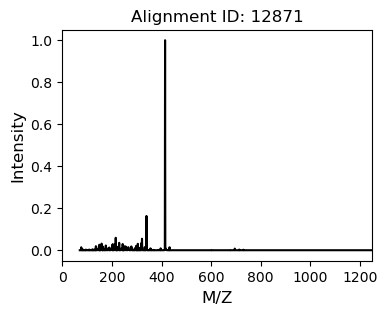

In [17]:
import matplotlib.pyplot as plt

Alignmnentid = 12871
df1= pd.DataFrame(df_pos_data_all.loc[Alignmnentid]).reset_index().rename(columns={'index':'mz',Alignmnentid:'exp'}).astype('float')

fig, axs = plt.subplots(1, 1, figsize=(4, 3))

axs.plot(df1['mz'], df1['exp'], color='black')
axs.set_xlabel('M/Z', fontsize=12)
axs.set_ylabel('Intensity', fontsize=12)
axs.set_title('Alignment ID: ' + str(Alignmnentid), fontsize=12)
axs.set_xlim(0, 1250)

plt.savefig('Data/svg/model/result/neg/rvalue_o-value_etherpc_dist.svg', format='svg', bbox_inches='tight')
plt.show()

In [18]:
Alignmnentid = 12871

element_list = df_pos_height[df_pos_height['Alignment ID'] == Alignmnentid]['MS/MS spectrum'].str.split(' ')

mz_list = []
int_list = []

for element in element_list:
    for i in element:
        i_div = i.split(':')
        mz = i_div[0]
        int_val = i_div[1]

        mz_list.append(mz)
        int_list.append(int_val)

df = pd.DataFrame(list(zip(mz_list, int_list))).rename(columns={0:'mz',1:'int'}).astype(float)
df.query('int > 50')

,mz,int
0,76.03838,213.0
18,133.10070,80.0
20,135.11648,281.0
32,145.10150,60.0
33,147.11509,262.0
...,...,...
229,414.30012,15127.0
239,415.29851,60.0
265,430.29716,68.0
267,432.30848,217.0


In [20]:
df_pred_result_all_X[df_pred_result_all_X['Alignment ID'] == 12871]['pred_class'].tolist()

['CAR:0.387,NAGly:0.152,GPNAE:0.047,DSMSE:0.035,SL:0.032,EtherLPE:0.029,DCAE:0.027,CoQ:0.027,DGDG:0.025,GD1a:0.021,OxTG:0.021,NAOrn:0.018,VAE:0.018,HexCer_HDS:0.014,GM3:0.013,GM1:0.011']